# IG generalised scvi run

# YS_project - scVI data integration

In [1]:
import sys,os
import scvi
import anndata
import matplotlib
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import scanpy as sc
import numpy.random as random
import scipy.sparse
import anndata

Global seed set to 0


In [2]:
import torch
device = torch.device("cuda")

In [3]:
# /nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/mikola_hannah_agm/IG_datasets/combined_datasets_by_organ/YS_vt_combined_hannah_mikola_all_tp.h5ad
# /nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_030522_notebooks/Integrating_HM_data_030522/YS_logit/YS_vt_HM_YS_LR_raw.h5ad

In [4]:
# scp -o ProxyCommand="ssh -W %h:%p ig7@ssh.sanger.ac.uk" ig7@farm5-login.internal.sanger.ac.uk:/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/mikola_hannah_agm/IG_datasets/combined_datasets_by_organ/YS_vt_combined_hannah_mikola_all_tp.h5ad ./
# scp -o ProxyCommand="ssh -W %h:%p ig7@ssh.sanger.ac.uk" ig7@farm5-login.internal.sanger.ac.uk:/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_030522_notebooks/Integrating_HM_data_030522/YS_logit/YS_vt_HM_YS_LR_raw.h5ad ./

In [5]:
# scp -o ProxyCommand="ssh -W %h:%p ig7@ssh.sanger.ac.uk" ig7@farm5-login.internal.sanger.ac.uk:/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/mikola_hannah_agm/IG_datasets/combined_datasets_by_organ/YolkSac_CS14_mikola_1.h5ad ./
# scp -o ProxyCommand="ssh -W %h:%p ig7@ssh.sanger.ac.uk" ig7@farm5-login.internal.sanger.ac.uk:/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/mikola_hannah_agm/IG_datasets/combined_datasets_by_organ/VitellineV_CS14_mikola_1.h5ad ./

In [6]:
 print(scvi.__version__)

0.16.2


In [7]:
 print(sc.__version__)

1.9.1


In [8]:
 print(anndata.__version__)

0.8.0


# Prepare dataset mergers

In [9]:
run_id = 'A5_V7_YS_build_120522'
# Required: Introduce the path you'd like to save figures or data to 
save_path = "/home/jupyter/mount/gdrive_2/g_cloud/projects/YS/data/A5_V1_YS_build_120522/"

## Load and prep data

In [14]:
adata_raw = sc.read("/home/jupyter/mount/gdrive_2/g_cloud/projects/YS/data/A5_V7_YS_build_120522/A2_V5_scvi_YS_integrated_raw_qc_scr_umap.h5ad")

In [15]:
adata = adata_raw[:]
#adata = list(adatas.values())[0].concatenate(list(adatas.values())[1:],join='inner')
#adata.var['g_int'] = False
#adata.var.loc[adata.var.index.isin(glist_int),['g_int']] = True
#adata_raw = adata.copy()
#adata[:, glist_int]

In [24]:
#adata_raw.write(save_path + '/run_'+ run_id+'_raw_feature_selected.h5ad')

/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


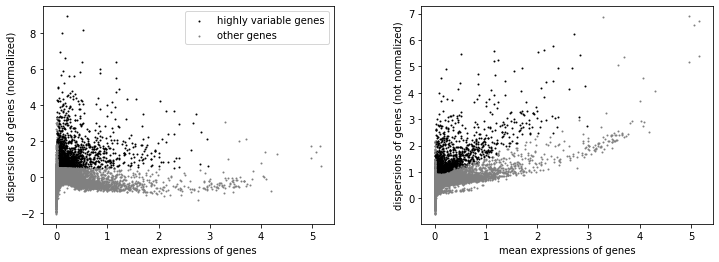

In [16]:
#sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, batch_key = "fetal.ids", subset=False)
sc.pl.highly_variable_genes(adata)

In [17]:
adata_raw

AnnData object with n_obs × n_vars = 170253 × 19015
    obs: 'cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids', 'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset', 'broad_cell_labels_organ', 'tissue', 'V6_old_indexes', 'dataset_merge', 'index_orig', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'organ', 'donor', 'new_data_handle', 'batch', 'HDBR_ID', 'leiden_scvi_res15', 'num', 'cell.labels_num', 'leiden_scvi_res15_num', 'clus_prediction', 'clus_prediction_num', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'restricted_leiden_scvi_res15', 'umap_density_clus_prediction', 'umap_density_clus_prediction_AEC', 'cell.labels_v2', 'cell.labels_v2_num'
    var: 'n_cells-0', 'mt-0', 'total_counts-0', 'highly_variable-0', 'intersect-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    

In [18]:
# adata_raw = sc.read('/home/jupyter/mount/gdrive/g_cloud/projects/YS/data/A5_V1_YS_build_120522/run_A5_V1_YS_build_120522_raw_feature_selected.h5ad')

In [19]:
adata_raw.write(save_path + '/run_'+ run_id+'_raw_.h5ad')

### Add batch key
Here we concatenate library prep method and donor of origin

## Param sweep for feature selection

In [20]:
import torch
device = torch.device("cuda")

def subset_top_hvgs(adata_lognorm, n_top_genes):
    dispersion_norm = adata_lognorm.var['dispersions_norm'].values.astype('float32')

    dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
    dispersion_norm[
                ::-1
            ].sort()  # interestingly, np.argpartition is slightly slower

    disp_cut_off = dispersion_norm[n_top_genes - 1]
    gene_subset = adata_lognorm.var['dispersions_norm'].values >= disp_cut_off
    return(adata_lognorm[:,gene_subset])

def prep_scVI(adata, 
              n_hvgs = 5000,
              remove_cc_genes = True,
              remove_tcr_bcr_genes = False
             ):
    ## Remove cell cycle genes
    if remove_cc_genes:
        adata = panfetal_utils.remove_geneset(adata,genes.cc_genes)

    ## Remove TCR/BCR genes
    if remove_tcr_bcr_genes:
        adata = panfetal_utils.remove_geneset(adata, genes.IG_genes)
        adata = panfetal_utils.remove_geneset(adata, genes.TCR_genes)
        
    ## HVG selection
    adata = subset_top_hvgs(adata, n_top_genes=n_hvgs)
    return(adata)

def train_scVI(adata, n_dims=20):
    adata = scvi.data.setup_anndata(adata, batch_key = "bbk", copy=True)
    vae = scvi.model.SCVI(adata, n_latent=n_dims)
    vae.train(use_gpu=True, batch_size=256) ## increasing batch size as in retina atlas
    return(vae.get_latent_representation())
    
def save_scVI(adata, 
              timestamp,
              n_hvgs = 5000,
              remove_cc_genes = True,
                remove_tcr_bcr_genes = False,
                n_dims=20
             ):
    outname = "YS_project".format(t=timestamp, h=n_hvgs, cc=cc, tcr=tcr, n=n_dims)
    np.save(data_dir + outname, adata.obsm["X_scVI"])


In [21]:
nhvgs = [5000,7500,10000]
dims = [10,20,30]

In [22]:
# for n in nhvgs:
#     for r in remove:
#         adata1 = prep_scVI(adata_raw, n_hvgs=n, remove_cc_genes=None, remove_tcr_bcr_genes=None)
#         for d in dims:
            
#             adata1.obsm["X_scVI"] = train_scVI(adata1, n_dims=d)
#             save_scVI(adata1, timestamp=timestamp, n_hvgs=n, None, remove_tcr_bcr_genes=None, n_dims=d)
#         del adata1
#         gc.collect()

# Subset_HVGS

In [23]:
# adata = adata_raw[:]

In [24]:
# sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, batch_key = "fetal.ids", subset=False)
# sc.pl.highly_variable_genes(adata)

In [25]:
adata = subset_top_hvgs(adata,5000)
var_genes = pd.DataFrame(list(adata.var.index))
#var_genes.to_csv(save_path + '/run_'+ run_id+'_var_genes.csv')
#adata.write(save_path + '/run_'+ run_id+'_norm_feature_selected.h5ad')

adata_raw = adata_raw[:, adata_raw.var_names.isin(list(var_genes.iloc[:,0]))]
adata_raw.layers['raw_counts'] = adata_raw.X.copy()
#adata_raw.write(save_path + '/run_'+ run_id+'_raw_feature_selected.h5ad')

In [26]:
adata_raw

AnnData object with n_obs × n_vars = 170253 × 5000
    obs: 'cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids', 'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset', 'broad_cell_labels_organ', 'tissue', 'V6_old_indexes', 'dataset_merge', 'index_orig', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'organ', 'donor', 'new_data_handle', 'batch', 'HDBR_ID', 'leiden_scvi_res15', 'num', 'cell.labels_num', 'leiden_scvi_res15_num', 'clus_prediction', 'clus_prediction_num', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'restricted_leiden_scvi_res15', 'umap_density_clus_prediction', 'umap_density_clus_prediction_AEC', 'cell.labels_v2', 'cell.labels_v2_num'
    var: 'n_cells-0', 'mt-0', 'total_counts-0', 'highly_variable-0', 'intersect-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    u

## Run scVI integration
We train using parameters optimized for online update with `scArches`, to be able to add query datasets in the future. Following the [scvi-tools vignette](https://docs.scvi-tools.org/en/stable/user_guide/notebooks/scarches_scvi_tools.html?highlight=encode_covariates#Train-reference).

In [28]:
adata_raw.var

,n_cells-0,mt-0,total_counts-0,highly_variable-0,intersect-0,means-0,dispersions-0,dispersions_norm-0,gene_ids-3,feature_types-3,genome-3,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
A1BG,3608,False,4549.0,False,True,0.032646,0.762440,0.202009,ENSG00000121410,Gene Expression,GRCh38,4682,False,4528,0.033701,97.350745,5760.0
A1CF,2507,False,5603.0,False,True,0.020899,0.899374,0.446998,ENSG00000148584,Gene Expression,GRCh38,3861,False,3114,0.043694,98.178052,7468.0
A2M,41086,False,183073.0,True,True,0.902951,1.954443,0.932011,ENSG00000175899,Gene Expression,GRCh38,60371,False,53298,1.473543,68.816261,251852.0
AAK1,29180,False,44416.0,False,True,0.296399,0.876983,0.406938,ENSG00000115977,Gene Expression,GRCh38,39033,False,37698,0.339336,77.943551,57998.0
AASS,3684,False,4037.0,False,True,0.030413,0.693421,0.078527,ENSG00000008311,Gene Expression,GRCh38,8091,False,7519,0.060790,95.600763,10390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSWIM4,2086,False,2168.0,False,True,0.017798,0.733328,0.149925,ENSG00000132003,Gene Expression,GRCh38,3527,False,3323,0.020729,98.055770,3543.0
ZSWIM6,15985,False,21124.0,False,True,0.152100,0.829615,0.322191,ENSG00000130449,Gene Expression,GRCh38,24319,False,23081,0.187186,86.495705,31993.0
ZSWIM8,12105,False,13628.0,False,True,0.110531,0.883015,0.417729,ENSG00000214655,Gene Expression,GRCh38,18313,False,17381,0.119919,89.830677,20496.0
ZWINT,29528,False,66869.0,True,True,0.296183,0.981141,0.593287,ENSG00000122952,Gene Expression,GRCh38,39130,False,37670,0.508981,77.959934,86993.0


In [37]:
adata = adata_raw.copy()

In [38]:
np.max(adata_raw.X)

31635.0

In [39]:
adata.obs['chemistry_ver'] = 'V1'
adata.obs.loc[adata.obs['orig.dataset'].isin(['YS_WE']),'chemistry_ver'] = 'V2'
adata.obs['lr_batch'] = adata.obs['fetal.ids'].astype(str) + '_' + adata.obs['chemistry_ver'].astype(str) 

In [41]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer=None,
    categorical_covariate_keys=["fetal.ids",'orig.dataset','chemistry_ver','stage'],
)
# deprecated
#scvi.data.setup_anndata(adata_raw, batch_key = "fetal.ids", copy=True)

# check if cuda is available

In [46]:
arches_params = dict(
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
    n_hidden=256
)
vae = scvi.model.SCVI(adata, n_latent=30,**arches_params)
vae.train(early_stopping=True,
        train_size=0.9,
        early_stopping_patience=45,
        max_epochs=250, 
        batch_size=1024, 
        limit_train_batches=20
       )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 250/250: 100%|██████████| 250/250 [05:30<00:00,  1.32s/it, loss=1.54e+03, v_num=1]


### Check convergence

In [47]:
data_dir = save_path
timestamp = '20220515'

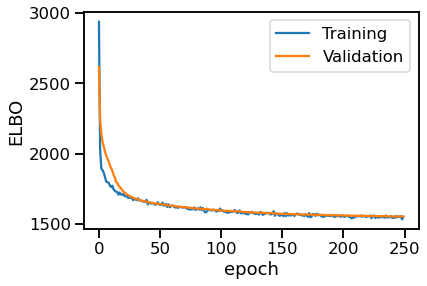

In [50]:
sns.set_context("talk")
plt.plot(vae.history["elbo_train"], label="Training");
plt.plot(vae.history["elbo_validation"], label="Validation");
plt.legend();
plt.xlabel("epoch");
plt.ylabel("ELBO");
plt.savefig("./scvi_training_elbo.pdf", bbox_inches="tight")

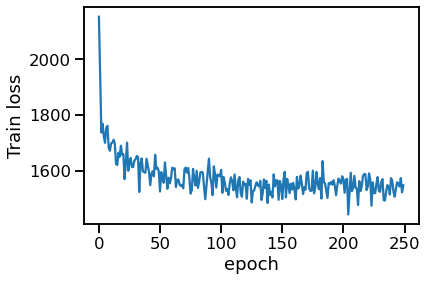

In [51]:
sns.set_context("talk")
plt.plot(vae.history["train_loss_step"], label="train");
# plt.plot(vae.history["reconstruction_loss_validation"], label="validation");
plt.xlabel("epoch");
plt.ylabel("Train loss");

In [52]:
## Save embedding
x_scvi = vae.get_latent_representation()
outname = "./YS_data_raw_count_v5_150522.scVI_out.npy"
np.save(outname, x_scvi)

In [53]:
## Save training stats
model_history = vae.history.copy()
model_history.pop('train_loss_step')
pd.DataFrame.from_dict({k:v[k] for k,v in model_history.items()}).to_csv("YS_data_raw_count.{t}.scVI_out.train_history.csv".format(t=timestamp))

In [54]:
# save the reference model
model_dir = 'scvi_PFI_model/'
if not os.path.exists(data_dir + model_dir):
    os.mkdir(data_dir + model_dir)
vae.save(data_dir + model_dir, overwrite=True)

In [58]:
pd.DataFrame(vae.get_latent_representation(),index = adata.obs.index).to_csv('./scvi_YS_outs_150522_v7.csv')

In [ ]:
pd.DataFrame(vae.get_latent_representation(),index = adata.obs.index)

## Explore output

In [ ]:
adata.obsm['X_scvi'] = vae.get_latent_representation() 
sc.pp.neighbors(adata, n_neighbors=30,use_rep='X_scvi', n_pcs = 20)
sc.tl.umap(adata)
# Clustering
res = 5
key_add = 'leiden_scvi_res5'
sc.pl.umap(adata,color = 'cell.labels_v2',size =10)
sc.tl.leiden(adata, resolution= res, key_added= key_add, random_state=26, n_iterations=-1)

In [66]:
adata.write('./A2_V7_SCVI_V7_30_30_normalised_YS.h5ad')

In [ ]:
sc.pl.umap(adata,color = 'cell.labels_v2',size =10)

In [ ]:
sc.pl.umap(adata,color = ['MS4A1','CD19','IGHM'],size =10) #'CCR10'

In [ ]:
sc.pl.umap(adata,color = ['fetal.ids'],size =10) #'CCR10'

In [ ]:
sc.pp.neighbors(adata, n_neighbors=15,use_rep='X_scvi', n_pcs = 20)
sc.tl.umap(adata)
# Clustering
res = 5
key_add = 'leiden_scvi_res5'
sc.pl.umap(adata,color = 'cell.labels',size =10)
sc.tl.leiden(adata, resolution= res, key_added= key_add, random_state=26, n_iterations=-1)

In [ ]:
adata = sc.read_h5ad('/mount/jupyter/mount/gdrive/g_cloud/projects/YS/data/A5_V1_YS_build_120522/run_A5_V1_YS_build_120522_norm_feature_selected.h5ad')

# DEGs

In [ ]:
de_df = vae.differential_expression(
        groupby="LVL3",
        delta=0.5,
        batch_correction=True
)

### Load results from scVI

In [ ]:
def load_scvi_outs(adata, emb_file):
    X_scVI_emb = np.load(emb_file)
    X_scVI_umap = np.load(emb_file.rstrip(".npy") + ".UMAP.npy")
    X_scVI_clust = pd.read_csv(emb_file.rstrip(".npy") + ".clustering.csv", index_col=0)
    adata.obsm["X_scvi"] = X_scVI_emb
    adata.obsm["X_umap"] = X_scVI_umap
    adata.obs["scvi_clusters"] = X_scVI_clust.loc[adata.obs_names]["leiden_150"].astype("category")

In [ ]:
load_scvi_outs(adata,'./YS_data_raw_count.{t}.scVI_out.npy')

In [ ]:
## Calculate KNN graph
sc.pp.neighbors(adata, use_rep = "X_scvi", n_neighbors = 30, key_added="scvi")

In [ ]:
obsp = adata.obsp.copy()

In [ ]:
adata.obsp = obsp

In [ ]:
adata.write('./Combined_YS_built_SCVI.h5ad')

In [39]:
adata_raw = sc.read('/home/jupyter/mount/gdrive/g_cloud/projects/YS/data/A5_V1_YS_build_120522/run_A5_V1_YS_build_120522_raw_feature_selected.h5ad')

In [40]:
adata_raw

AnnData object with n_obs × n_vars = 194978 × 1751
    obs: 'cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids', 'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset', 'broad_cell_labels_organ', 'tissue', 'V6_old_indexes', 'dataset_merge', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'organ', 'donor', 'new_data_handle', 'batch', 'HDBR_ID'
    var: 'n_cells-0', 'mt-0', 'total_counts-0', 'highly_variable-0', 'intersect-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_ids-3', 'feature_types-3', 'genome-3', 'g_int'
    layers: 'raw_counts'